In [2]:
#from starter code
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, desc
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [5]:
#from starter code
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

# Exploratory Climate Analysis

* Calculate the date 1 year ago from the last data point in the database

In [6]:
date_data = session.query(func.max(Measurement.date)).all()
pprint(date_data)

#Last date in DB is 2017-08-23, one year prior would be 2016-08-23

[('2017-08-23',)]


* Perform a query to retrieve the data and precipitation scores

In [7]:
precip_data = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= dt.date(2016, 8, 23), Measurement.date <= dt.date(2017, 8, 23)).all()
#pprint(precip_data)

* Save the query results as a Pandas DataFrame and set the index to the date column

* Sort the dataframe by date

In [8]:
df_meas_precipdata_unclean = pd.DataFrame(precip_data, columns = ["Precipitation", "Date"]).dropna()
df_meas_precipdata_date_unclean = df_meas_precipdata_unclean["Date"]
df_meas_precipdata_date_clean = pd.DataFrame(pd.to_datetime(df_meas_precipdata_date_unclean))
df_meas_precipdata_precip = df_meas_precipdata_unclean["Precipitation"]
df_meas_precipdata_precipdf = pd.DataFrame(df_meas_precipdata_precip)
df_meas_precipdata_clean = df_meas_precipdata_date_clean.join(df_meas_precipdata_precipdf).set_index("Date")
df_meas_precipdata_clean
#Data was already sorted by date in the SQL Query.

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-17,0.13
2017-08-19,0.09
2017-08-21,0.56


* Use Pandas Plotting with Matplotlib to plot the data

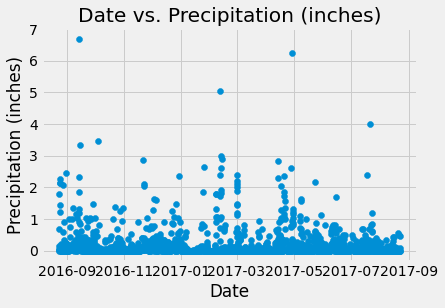

In [9]:
plt.title("Date vs. Precipitation (inches)")
x= df_meas_precipdata_clean.index
y= df_meas_precipdata_clean["Precipitation"]
plt.scatter(x, y)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.rcParams["figure.figsize"] = (15,15)
plt.show()

* Use Pandas to calcualte the summary statistics for the precipitation data

In [10]:
df_meas_precipdata_clean.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

* Design a query to show how many stations are available in this dataset?

In [11]:
unique_stations = session.query(func.count(distinct(Measurement.station))).all()
pprint(unique_stations)

[(9,)]


*What are the most active stations? (i.e. what stations have the most rows)?
*List the stations and the counts in descending order.

In [12]:
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
pprint(active_stations)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


* Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?

In [13]:
temp_stations = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).limit(1).all()
pprint(temp_stations)

[('USC00519281', 54.0, 85.0, 71.66378066378067)]


* Choose the station with the highest number of temperature observations.
* Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [21]:
temp_active = session.query(Measurement.station, Measurement.tobs, Measurement.date).filter(Measurement.station  == "USC00519281").filter(Measurement.date >= dt.date(2016, 8, 23), Measurement.date <= dt.date(2017, 8, 23)).all()
temp_active_df_unclean = pd.DataFrame(temp_active)
temp_active_date = temp_active_df_unclean["date"]
temp_active_date_clean = pd.DataFrame(pd.to_datetime(temp_active_date))
temp_active_df_unclean2 = temp_active_df_unclean
temp_active_df_unclean3 = temp_active_df_unclean2.drop(columns = "date")
temp_active_df = (temp_active_df_unclean3.join(temp_active_date_clean)).set_index("date")

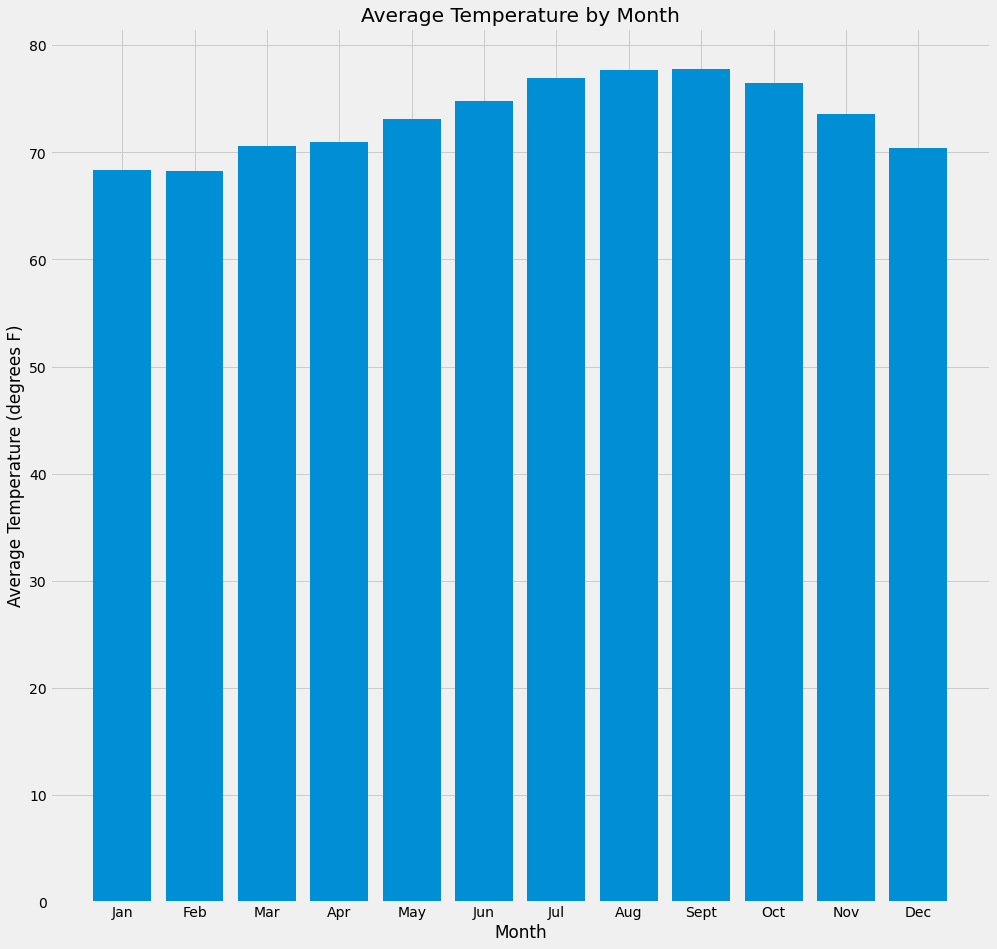

In [37]:
temp_active_monthly_df = temp_active_df.groupby(by=[temp_active_df.index.month]).mean()
tx = temp_active_monthly_df.index
ty = temp_active_monthly_df["tobs"]
plt.bar(tx, ty, tick_label = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.xlabel("Month")
plt.ylabel("Average Temperature (degrees F)")
plt.title("Average Temperature by Month")
plt.show()
#Histogram seemed meaningless to me here; much better to show this properly broken out by month

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`